In [1]:
# Assignment 8
# Tracking and forecasting in conditions of measurement gaps.
# Team 2:
#     Ekaterina Karmanova
#     Timur Chikichev
#     Iaroslav Okunevich
#     Nikita Mikhailovskiy
#
# Skoltech, 14.10.2019

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random

In [3]:
#1
# Array with 𝜎a2 and 𝜎𝜂2
sigmasTrue=[0.2,20]
acc= np.random.normal(0, sigmasTrue[0], 200)

def Velocity (size,acc,t):
        vel=np.zeros((size))
        vel[0]=1
        for i in range(1,size):
                vel[i]=vel[i-1]+acc[i-1]*t
        return vel
        
def Trajectory(size,acc,vel,t):
        trajectory=np.zeros((size))
        trajectory[0]=5
        for i in range(1,size):
                trajectory[i]=trajectory[i-1]+vel[i-1]*t+acc[i]*t*t/2
        return trajectory
velocity=Velocity(200,acc,1)
traject=Trajectory(200,acc,velocity,1)

In [4]:
#2
def Measurements(x,ny,p):
        z=np.zeros(len(x))
        for i in range(0, len(x)):
            rand=random.random()
            if rand>p:
                z[i]=x[i]+ny[i]
            else:
                z[i]=np.nan
        return z

ny= np.random.normal(0, sigmasTrue[1], 200)
z=Measurements(traject,ny,0.2)

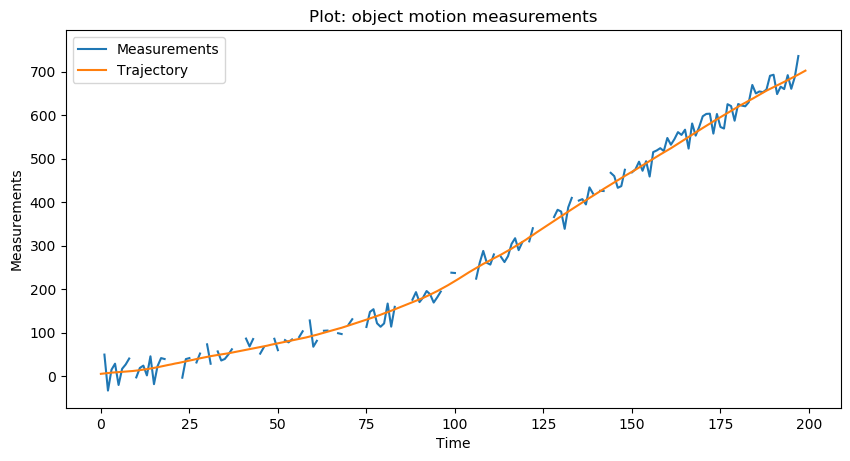

In [5]:
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot: object motion measurements')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(z,label='Measurements')
plt.plot(traject,label='Trajectory')
plt.legend()
plt.show()  

In [6]:
def SetupFi(t):
    return np.matrix([[1,t],[0,1]])
def SetupG(t):
    return np.matrix([[(t**2)/2],[t]])
H=np.matrix([1,0])
FI=SetupFi(1)
G=SetupG(1)

In [7]:
def TrajectoryMatrix(size,acc,fi,g):
        trajectory=np.zeros([size,2])
        trajectory = trajectory[:,:]
        trajectory[0,0]=2
        trajectory[0,1]=0
        for i in range(1,size):
            matrix=np.matrix([[trajectory[i-1,0]],
                              [trajectory[i-1,1]]])
            column=fi.dot(matrix)+g*acc[i]
            trajectory[i]=column.transpose() 
        trajectory=trajectory.transpose()
        return trajectory
    
trajectoryMatrix=TrajectoryMatrix(200,acc,FI,G)

In [8]:
def MeasurementsMatrix(x,ny,h,p):    
        z=np.zeros(len(ny))
        for i in range(0, len(ny)):
            rand=random.random()
            if rand>p:
                matrix=np.matrix([[x[0,i]],
                                 [x[1,i]]])
                z[i]=h.dot(matrix)+ny[i]
            else:
                z[i]=np.nan
        return z

z=MeasurementsMatrix(trajectoryMatrix,ny,H,0.2)

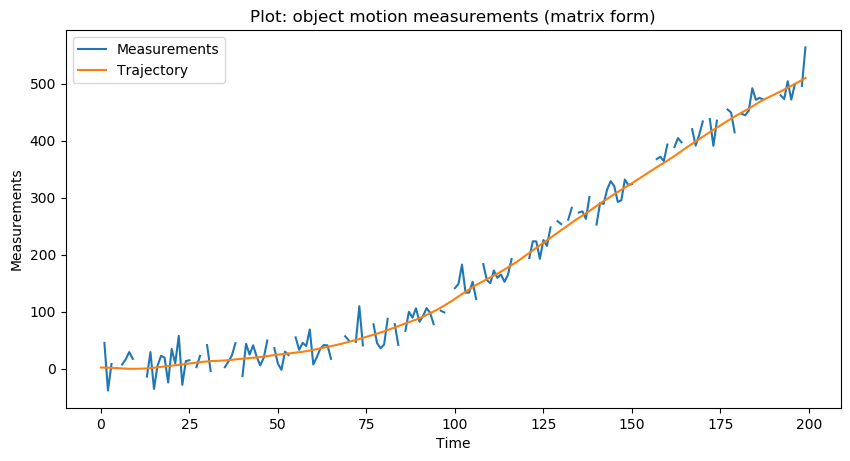

In [9]:
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot: object motion measurements (matrix form)')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(z,label='Measurements')
plt.plot(trajectoryMatrix[0],label='Trajectory')
plt.legend()
plt.show()  

In [10]:
def SetupQ(G,sigmaA):
    return np.dot(G,G.transpose())*sigmaA
Q=SetupQ(G,sigmasTrue[0]**2)

R=sigmasTrue[1]**2

def PPrediction(p00,fi,q):
    return np.dot(np.dot(fi,p00),fi.transpose())+q

def XPrediction(fi,x10):
    return np.dot(fi,x10)

def FindKI(pIIMinus1,h,r):
    onePart=np.dot(pIIMinus1,h.transpose())
    secondpart=np.dot(np.dot(h,pIIMinus1),h.transpose())+r
    return onePart*secondpart.I

def FindPII(pIIMinus1,k,h):
    return np.dot(np.eye(2)-np.dot(k,h),pIIMinus1)

def FindXI(xI,k,zI,h):
    return xI+k*(zI-h*xI)

In [11]:
def Kalman(z,h,fi,q,r,pFiltration=np.matrix([[10000, 0],
                                             [0, 10000]])):
    arrayK=np.zeros(len(z))
    pFilterArray=np.zeros(len(z))
    tracjectKalman=np.zeros((2,len(z)))
    tracjectKalman[0,0]=2
    tracjectKalman[1,0]=0    
    x0=np.matrix([[2],
                  [0]])
    pFilterArray[0]=np.sqrt(pFiltration[0,0])
    for i in range(1,len(z)):
        pPrediction=PPrediction(pFiltration, fi, q) 
        xPred=XPrediction(fi,x0)
        k=FindKI(pPrediction,h,r)
        if np.isnan(z[i]):
            x0=xPred
            pFiltration=pPrediction
        else:
            x0=FindXI(xPred,k,z[i],h)
            pFiltration=FindPII(pPrediction,k,h) 
        
        pFilterArray[i]=np.sqrt(pFiltration[0,0])        
        tracjectKalman[0,i]=x0[0]
        tracjectKalman[1,i]=x0[1]
        arrayK[i]=k[0]
    arrayK=np.delete(arrayK, 0)
    pFilterArray=np.delete(pFilterArray, 0)
    return tracjectKalman, arrayK, pFilterArray
tracjectKalman, arrayK, pFilterArray=Kalman(z,H,FI,Q,R)

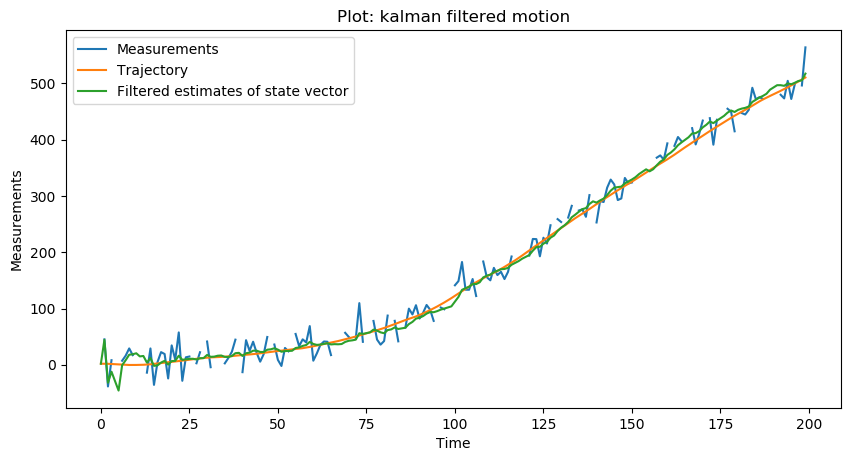

In [12]:
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot: kalman filtered motion')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(z,label='Measurements')
plt.plot(trajectoryMatrix[0],label='Trajectory')
plt.plot(tracjectKalman[0],label='Filtered estimates of state vector')
plt.legend()
plt.show()  

In [13]:
#3
def Extrapolation(tracjectKalman,fi,size=7):
    fiM=np.eye(2)
    trajectoryExtrapolation=np.zeros([2,200])
    for i in range(0,7):
        trajectoryExtrapolation[0,i]=tracjectKalman[0,i]
        trajectoryExtrapolation[1,i]=tracjectKalman[1,i]
        fiM = fiM.dot(fi)
    for i in range(size,200):
        x=np.matrix([[tracjectKalman[0,i-7]],
                     [tracjectKalman[1,i-7]]])
        xExrt=fiM.dot(x)        
        trajectoryExtrapolation[0,i]=xExrt[0]
        trajectoryExtrapolation[1,i]=xExrt[1]
    return trajectoryExtrapolation
kalmanExp=Extrapolation(tracjectKalman,FI,7)

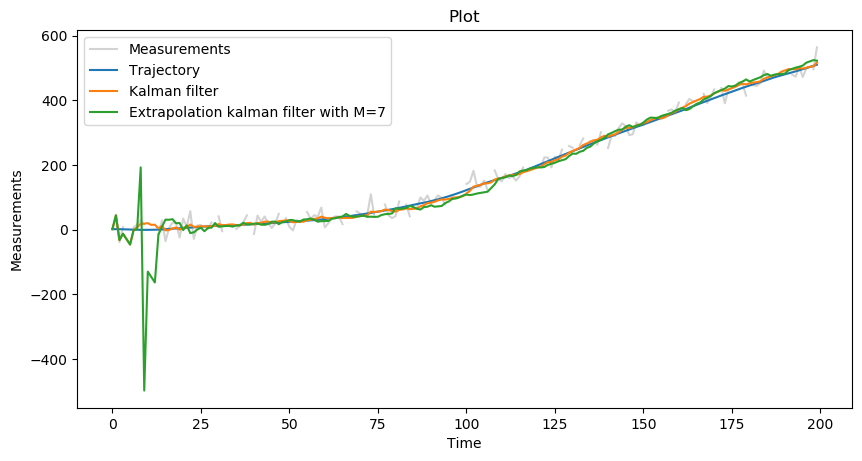

In [14]:
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(z,label='Measurements',c='lightgrey')
plt.plot(trajectoryMatrix[0],label='Trajectory')
plt.plot(tracjectKalman[0],label='Kalman filter')
plt.plot(kalmanExp[0],label='Extrapolation kalman filter with M=7')
plt.legend()
plt.show()  

In [15]:
def FinalError(H,FI,Q,R,G,runs,exp=False,pFiltration=np.matrix([[10000, 0],[0, 10000]]),step=7,p=0.2):
    error=0
    finalError=np.zeros(200)
    for i in range(runs):
        
        a= np.random.normal(0, 0.2, 200)
        trajectoryMatrix=TrajectoryMatrix(200,a,FI,G)        
        ny= np.random.normal(0, 20, 200)
        z=MeasurementsMatrix(trajectoryMatrix,ny,H,p)
        tracjectKalman, garbage, garbage1=Kalman(z,H,FI,Q,R,pFiltration)
        
        if exp:
            tracjectKalman=Extrapolation(tracjectKalman,FI,step)
                
        for j in range(int(trajectoryMatrix.size/len(trajectoryMatrix))):
            finalError[j]+=(trajectoryMatrix[0,j]-tracjectKalman[0,j])**2
    for i in range(int(trajectoryMatrix.size/len(trajectoryMatrix))):
        finalError[i]=np.sqrt(finalError[i]/(runs-1)) 
    finalError=np.delete(finalError, 0)
    return finalError

In [16]:
finalError7=FinalError(H,FI,Q,R,G,500)
finalErrorExp7=FinalError(H,FI,Q,R,G,500,True)
finalErrorExp1=FinalError(H,FI,Q,R,G,500,True,step=1)

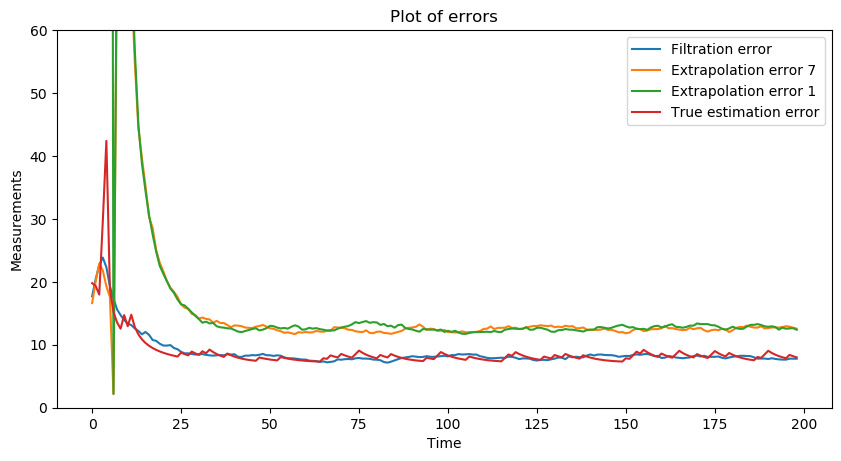

In [17]:
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot of errors')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(finalError7,label='Filtration error')
plt.plot(finalErrorExp7,label='Extrapolation error 7')
plt.plot(finalErrorExp1,label='Extrapolation error 1')
plt.plot(pFilterArray,label='True estimation error')
plt.ylim(0,60)
plt.legend()
plt.show()  

In [18]:
#4
finalError03=FinalError(H,FI,Q,R,G,500,p=0.3)
finalErrorExp703=FinalError(H,FI,Q,R,G,500,True,p=0.3)
finalErrorExp103=FinalError(H,FI,Q,R,G,500,True,step=1,p=0.3)
#finalError05=FinalError(H,FI,Q,R,G,500,p=0.5)
finalErrorExp705=FinalError(H,FI,Q,R,G,500,True,p=0.5)
finalErrorExp105=FinalError(H,FI,Q,R,G,500,True,step=1,p=0.5)
#finalError07=FinalError(H,FI,Q,R,G,500,p=0.7)
finalErrorExp707=FinalError(H,FI,Q,R,G,500,True,p=0.7)
finalErrorExp107=FinalError(H,FI,Q,R,G,500,True,step=1,p=0.7)

In [19]:
finalError=FinalError(H,FI,Q,R,G,500,p=0.2)

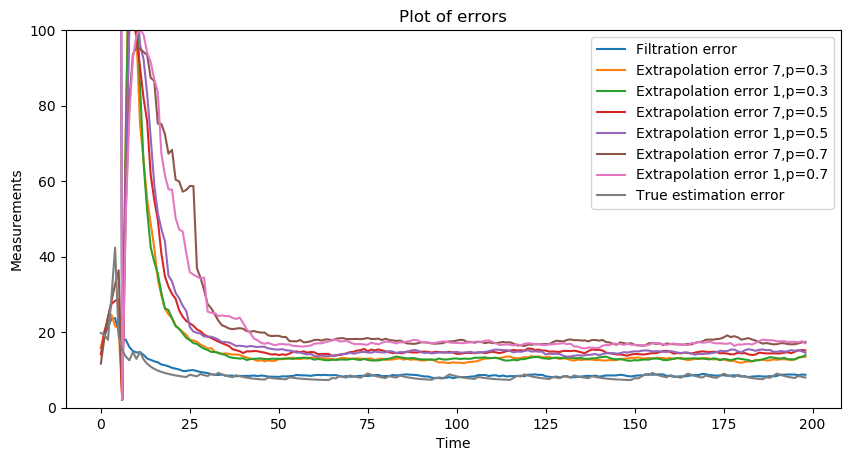

In [20]:
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot of errors')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(finalError03,label='Filtration error')
plt.plot(finalErrorExp703,label='Extrapolation error 7,p=0.3')
plt.plot(finalErrorExp103,label='Extrapolation error 1,p=0.3')
plt.plot(finalErrorExp705,label='Extrapolation error 7,p=0.5')
plt.plot(finalErrorExp105,label='Extrapolation error 1,p=0.5')
plt.plot(finalErrorExp707,label='Extrapolation error 7,p=0.7')
plt.plot(finalErrorExp107,label='Extrapolation error 1,p=0.7')
plt.plot(pFilterArray,label='True estimation error')
plt.ylim(0,100)
plt.legend()
plt.show()  